---
---
<h2><center>Institut für Astrophysik, Universität Wien, Türkenschanzstrasse 17, 1180 Wien  </center></h2>
<h1><center><ins>Numerical Astrophysics (WS25):</ins></center></h1>
<h2><center>Mini Project 3: Fitting & testing </center></h2>

<h2><center>Eva Freistetter, 09903050 </center></h2>

Date: February 11th, 2026
---
---

# (A) Assignement: Project 3

Write a code which fits the depth and the length of an exoplanetary transit. A transit is an event when an exoplanet passes in front of its host star as seen from the Earth, which causes the apparent dimming in the stellar light. Usually, multiple transits are observed until the presence of an exoplanet is confirmed, but in this simple example we consider a single transit (Fig.3). 

- Load the transit data from the file ArtificialTransitData.txt into your code.
- Generate your own transit, and move it along the time line as shown in Fig 3 with the red line.
- Calculate the χ2. Vary the transit depth and the transit length and fit the best pair which produces the smallest χ2.
-  Benchmark the code.
-  Use pytest for testing your code. Assert that
    -  i) the fitted depth is close to the true injected depth (within 15%);
    -  ii) test the behaviour when pure noise (no transit) into the fitter and check that your programme doesn’t “imagine” a deep signal (check for false positives for this test, you will need to add a small random noise to your generated transit);
    -  iii) check that the code does not generate negative transit duration and depth (physics sanity check).




# Preliminary remarks

# Notes concerning the noise level of the dataset

The artificial dataset does not provide real measurement uncertainties. I had to estimate the noise level $\sigma$ directly from the data. I decided not to calculate the difference between <code>flux</code> and <code>flux_noiseless</code> because that is just a measure of how much any single points deviates from the noiseless model. A valid measurement of uncertainty that can be used in a $χ^2$ test should describe the statistical scatter of many repeated measurements. Also, using point-by-point differences can result in extremly small values of individual errors (leading to unrealistically large contributions to  $χ^2$)

I could have used the scatter of the <code>flux</code> outside the transit (assuming that those datapoints represent the noise) and calculated the standard deviation for these points. This $\sigma$ could then be used as a single, representative noise level for the $χ^2$ calculation. But to get a code that is able to work also with files that do not include any <code>in_transit</code> information I chose to caluclate $\sigma$ by using a median absolute deviation of the flux (because standard deviation would overestimate the noise because of the transit.)

# Notes concerning the search grid for the transit fitting function

### 1) Transit depth d

The lowest value of d is $d=0$, i.e. no transit at all. The highest meaningful value depends on the size of the star in comparison to the size of the transiting body. The transit depth d is of the order $(R_p/R_\star)^2$ (see e.g. https://exoplanetarchive.ipac.caltech.edu/docs/transit/transit_algorithms.html). For an earth-like planet orbit the sun, the ratio of radii is ~0.01 and the transit depth about 0.01 percent. A jupiter-like planet would result in a transit depth of 1 percent and in the case of a very large gas giant orbiting a small star, one can expect a transit depth of ~5 percent. I thus chose 5% as an upper limit for a meaningful transit depth when searching for planetary transits and evaluate the model for 100 intervalls of equal size between $d = 0$ and $d = 0.05$:

<code>d_grid = np.linspace(0.0, 0.05, 101)</code>

### 2) Transit duration T

The duration of a planetary transit is determined by the size of the star and the orbital geometry. $T \sim P/a \cdot R_\star$ (with P the period of the planet and a the semimajor axis of its orbit). Typical transits have a duration of some hours - the NASA Exoplanet Archive https://exoplanetarchive.ipac.caltech.edu/ shows that most confirmed exoplanets have transit durations between $~2$ and $~4$ hours and only very few transits have a duration longer than 8 hours. I thus chose 100 intervalls of T between 0.5 hours ($~0.02$ days) and 8 hours ($~0.33$ days):  

<code>T_grid = np.linspace(0.02, 0.33, 101)</code>

## 3) Start of Transit $t_1$

I assumed that the transit could take place anywhere in the time $[t_{min}, t_{max}]$ given by the artifical data. Thus, the earliest possible starting time is $t1 = t_{min}$ and the latest possible time is $t1 = t_{max} - T$. The values in between have to be sampled with a timestep, that is not too large (because that increases the error of the fit) and not too small (because that increases the total running time of the code). The timestep should be chosen according to the sampling rate of the given data. It is not meaningful, to choose the timestep very much smaller than this sampling rate and it should of course also not be much larger. The artifical transit data are sampled with a resolution of $~0.001 d$ which is chosen as timestep for the fitting function: 

<code>t1_step = 0.001 </code>


# Notes concerning the baseline of the flux

The baseline is the mean level of the flux outside of transit. In the given artificial data the baseline is at $flux = 1$. But I chose not to threat that as given for every possible data set. If the mean out-of-transit flux of a dataset is not exactly 1 due to noise, normalization errors, or systematic errors, a fitting function assuming a baseline fixed to 1 can give biased parameters or false transit detections. In the code, I thus included a section that normalizes the data.


# (B) Transit-Fitting (without Benchmarking and Pytest)

--- Basic information on dataset: ---
  Number of points     = 720
  Sigma   = 0.0005533182016892063
  Baseline  = 0.9998847449999999
  time step between measurements  = 0.001388890000000002

--- Best-Fit: ---
  # models    = 6059394
  depth d     = 0.01
  duration T  = 0.1223
  start t1    = -0.06249965000000757
  chi2        = 801.2333716786796
  chi2_red    = 1.117480295228284
  degrees of freedom          = 717


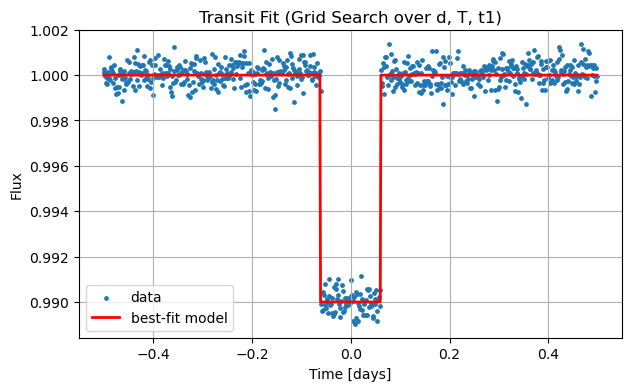

In [5]:
import numpy as np
import matplotlib.pyplot as plt

##########################################################
# Transit model: fitting simple box-shaped transit on a normalized baseline (= 1)
# Parameters:
# - time: time array
# - t_transit: transit duration T (days)
# - d_transit: transit depth d (relative flux drop, e.g. 0.01 = 1%)
# - t1: transit start time (days)
# Returns:
# - flux_model: model flux values at each time stamp
#########################################################

def create_flux_model(time, t_transit,d_transit,t1):
    t2=t1+t_transit
    flux_model=np.ones_like(time)
    in_window = (time >= t1) & (time <= t2)
    flux_model[in_window] = 1.0 - d_transit
    return flux_model

#########################################################
# Chi-square statistic for model comparison:
# chi2 = sum( ((data - model) / sigma)**2 )
# sigma can be a float (constant uncertainty) or an array (per-point uncertainties)
#########################################################
def chi2_test(flux, flux_model, sigma):
    return np.sum(((flux - flux_model) / sigma)**2)

#########################################################
# Fitting function
# Scans over transit duration T, transit depth d, and transit start time t1
# Keeps the parameter set with the minimum chi2
#########################################################

def fit_transit(time, flux, sigma, d_grid, T_grid, t1_step):
    # Define the allowed time window from the data
    t_min = time.min()
    t_max = time.max()

   # Initialize "best-fit" storage
    best_chi2 = np.inf
    best_d = None
    best_T = None
    best_t1 = None
    best_model = None

    # Count the models that are tested
    count = 0
    # Loop over candidate transit durations 
    for T in T_grid:
        # Physics test: negative or zero duration makes no sense
        # such values will be ignored for the fit
        if T <= 0:
            continue

        # For a given duration, restrict t1 so that the transit fully fits into the data window
        t1_min = t_min
        t1_max = t_max - T
        
        # Physics test: End of transit must be after start of transit
        if t1_max <= t1_min:
            continue

        # Build the grid of candidate start times t1
        # The additional + 0.5*t1_step ensures that the upper boundary is included
        # despite floating-point rounding and the half-open nature of np.arange.
        t1_grid = np.arange(t1_min, t1_max + 0.5 * t1_step, t1_step)

        # Loop over candidate transit depths 
        for d in d_grid:
            
            # Physics test: negative depth makes no sense
            if d < 0:
                continue

            # Loop over candidate start times (shifting the transit along the timeline)
            for t1 in t1_grid:

                count = count + 1
                # Generate the model light curve for this parameter set
                model = create_flux_model(time, T, d, t1)
                
                # Compute chi-square between observed flux and model
                chi2 = chi2_test(flux, model, sigma)

                # Update best-fit if this chi2 is smaller
                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_d = d
                    best_T = T
                    best_t1 = t1
                    best_model = model
    # Return best-fit parameters and the best-fit model curve
    return best_d, best_T, best_t1, best_chi2, best_model, count


########################################################
# Step 1: Load the provided artificial transit dataset
# Columns:
# - time: time stamps
# - flux: noisy observed flux
# - flux_noiseless: noiseless injected transit model
# - in_transit: 1 if point is in transit, 0 if out of transit 
#########################################################

transitdata = "ArtificialTransitData_mini-project_3.txt"

time=np.loadtxt(transitdata, usecols=0, skiprows=1, dtype=float)  
flux=np.loadtxt(transitdata, usecols=1, skiprows=1, dtype=float)  
flux_noiseless=np.loadtxt(transitdata, usecols=2, skiprows=1, dtype=float)  
in_transit=np.loadtxt(transitdata, usecols=3, skiprows=1, dtype=int) 

# Number of data points in the set
N = time.size

# Start with calculaton of robust baseline estimate:
# Median is stable even if a small fraction of points are in transit
baseline = np.median(flux)
# Normalize flux so that the baseline is approximately 1
flux = flux / baseline
# Robust noise estimate using MAD (Median Absolute Deviation) on the normalized flux
# The factor 1.4826 converts MAD to an equivalent 1-sigma estimate for Gaussian noise
sigma = 1.4826 * np.median(np.abs(flux - 1.0))


#########################################################
# Define search grids for transit parameters
# - d_grid: transit depth candidates: (0 ... 5%)
# - T_grid: transit duration candidates: (0.02 ... 0.33) (in days)
# - t1_step: grid step size for transit start time, chosen from the data sampling
#########################################################

d_grid = np.linspace(0.0, 0.05, 101)      # Tiefen 0 ... 5%
T_grid = np.linspace(0.02, 0.33, 101)      # Dauern in Tagen (Beispiel)
dt = np.diff(time)
t1_step = np.median(dt)

# Basic dataset information

print("--- Basic information on dataset: ---")
print("  Number of points     =", N)
print("  Sigma   =", sigma)
print ("  Baseline  =", baseline)
print("  time step between measurements  =", t1_step)
print("")

#Fit of the transit
best_d, best_T, best_t1,  best_chi2, best_model, models = fit_transit(time, flux, sigma, d_grid, T_grid, t1_step)

# Print best-fit results and compute reduced chi-square
# We fit three parameters (d, T, t1) --> degrees of freedom = N - 3
print("--- Best-Fit: ---")
print("  # models    =", models)
print("  depth d     =", best_d)
print("  duration T  =", best_T)
print("  start t1    =", best_t1)
print("  chi2        =", best_chi2)
dof = N - 3
chi2_red = best_chi2 / dof
print("  chi2_red    =", chi2_red)
print("  degrees of freedom          =", dof)

# Plot data and best-fit model
plt.figure(figsize=(7,4))
plt.scatter(time, flux, s=6, label="data")
plt.plot(time, best_model, lw=2, color="r", label="best-fit model")
plt.xlabel("Time [days]")
plt.ylabel("Flux")
plt.title("Transit Fit (Grid Search over d, T, t1)")
plt.legend()
plt.grid(True)
plt.show()

## Output and Interpretation:

The code has tested more than 6 million transit models against the data set.
The fitting function recovers exactly the injected transit depth of 0.01 in the dataset. 
The tranist time of the fit is 0.1223 days or 2.9 hours, which is very close to the injected transit time of 2.86 hours.
The starting time of the transit is determined by the fit with -0.06249965 which is between the two time points of the data set, where the transit starts.

**The fitting code finds the correct transit**

The calculated $χ^2$ of the fit is 1.12, which is a very good fit. 


<hr>
<hr>

# (C) Program 2: Transit-Fitting with Benchmarking

## Benchmarking

This code checks the scaling of the runtime. The transit fitting function searches on a grid over transit duration $T$, depth $d$, and start time $t_1$. For each parameter combination, a model light curve is generated and a $\chi^2$ value is computed over all data points. 

If the grid over $T$ or $d$ gets finer the general scaling is linear:

$$
\text{runtime} \propto  N_T \cdot N_d
$$

The number of different starting times used in the fitting function depens on <code>t1_step</code>. The interval of physically meaningful transit start times is $[\left(t_{max} - T\right) - t_{min}]$. The number of tested models for starting times is thus:


$$
N_{t_1} \approx \frac{\left(t_{max} - T\right) - t_{min}}{t1\_step} \propto \frac{1}{t1\_step}.
$$


Additionally, there is also a dependency of the runtime on the number of data points $N$, because for every model, $\chi^2$ is evaluated with a loop over N. 

In total, the runtime is expected to be proportional to:

$$
\text{runtime} \propto N \cdot N_T \cdot N_d \cdot \frac{1}{\Delta t_1}.
$$

This scaling behaviour is verified explicitly by benchmarking the code with different grid resolutions and start-time step sizes.



--- Basic information on dataset: ---
  Number of points     = 720
  Sigma 2   = 0.0005533182016892063
  Baseline  = 0.9998847449999999
  time step between measurements  = 0.001388890000000002


--- BENCHMARK RESULTS ---
Nd   NT   t1_step(days)   models_tested      runtime_med(s)   chi2_red
 51  51     0.002778       773772         29.005 1.6025057
 51  51     0.001389      1544994         58.495 1.5960508
 51  51     0.000694      3087387        116.486 1.1312241
101 101     0.002778      3034747        113.845 1.1996436
101 101     0.001389      6059394        224.675 1.1174803
101 101     0.000694     12108587        455.366 1.1174803
151 151     0.002778      6783222        254.112 0.7240112
151 151     0.001389     13543794        503.922 0.7240112
151 151     0.000694     27064787       1012.937 0.7240112


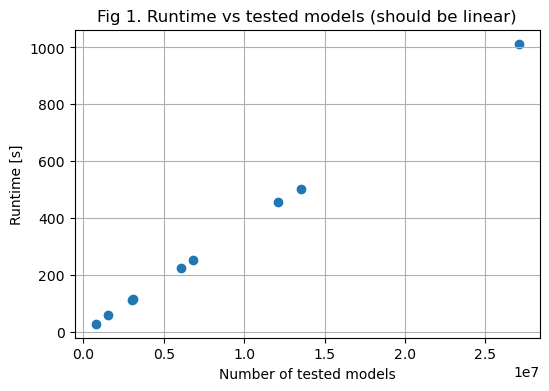

Estimated scaling exponent alpha = 0.9975516577516893


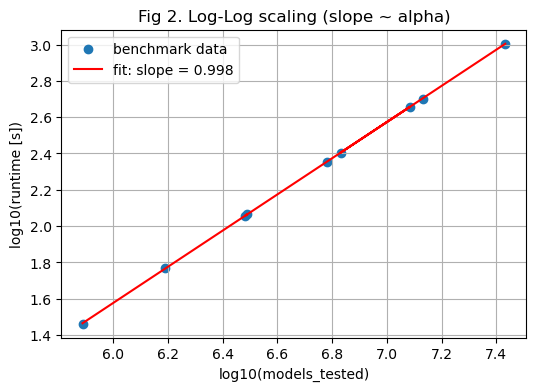

Time per model: min / median / max = 3.7078790387290034e-05 3.748520235935265e-05 3.7860988456912444e-05


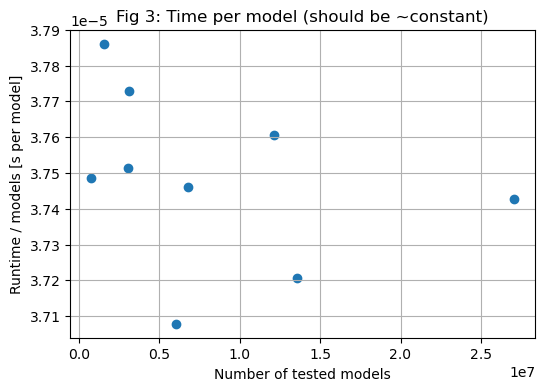

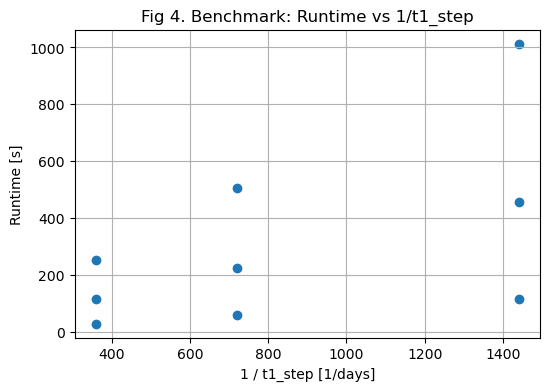

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm

##########################################################
# Transit model: fitting simple box-shaped transit on a normalized baseline (= 1)
# Parameters:
# - time: time array
# - t_transit: transit duration T (days)
# - d_transit: transit depth d (relative flux drop, e.g. 0.01 = 1%)
# - t1: transit start time (days)
# Returns:
# - flux_model: model flux values at each time stamp
#########################################################

def create_flux_model(time, t_transit,d_transit,t1):
    t2=t1+t_transit
    flux_model=np.ones_like(time)
    in_window = (time >= t1) & (time <= t2)
    flux_model[in_window] = 1.0 - d_transit
    return flux_model

#########################################################
# Chi-square statistic for model comparison:
# chi2 = sum( ((data - model) / sigma)**2 )
# sigma can be a float (constant uncertainty) or an array (per-point uncertainties)
#########################################################
def chi2_test(flux, flux_model, sigma):
    return np.sum(((flux - flux_model) / sigma)**2)

#########################################################
# Fitting function
# Scans over transit duration T, transit depth d, and transit start time t1
# Keeps the parameter set with the minimum chi2
#########################################################

def fit_transit(time, flux, sigma, d_grid, T_grid, t1_step):
    # Define the allowed time window from the data
    t_min = time.min()
    t_max = time.max()

    # Initialize "best-fit" storage
    best_chi2 = np.inf
    best_d = None
    best_T = None
    best_t1 = None
    best_model = None

    # Count the models that are tested
    count = 0
    # Loop over candidate transit durations 
    for T in T_grid:
        # Physics test: negative or zero duration makes no sense
        if T <= 0:
            continue

        # For a given duration, restrict t1 so that the transit fully fits into the data window
        t1_min = t_min
        t1_max = t_max - T
        
        # Physics test: End of transit must be after start of transit
        if t1_max <= t1_min:
            continue

        # Build the grid of candidate start times t1
        # The additional + 0.5*t1_step ensures that the upper boundary is included
        # despite floating-point rounding and the half-open nature of np.arange.
        t1_grid = np.arange(t1_min, t1_max + 0.5 * t1_step, t1_step)

        # Loop over candidate transit depths 
        for d in d_grid:
            
            # Physics test: negative depth makes no sense
            if d < 0:
                continue

            # Loop over candidate start times (shifting the transit along the timeline)
            for t1 in t1_grid:

                count = count + 1
                # Generate the model light curve for this parameter set
                model = create_flux_model(time, T, d, t1)
                
                # Compute chi-square between observed flux and model
                chi2 = chi2_test(flux, model, sigma)

                # Update best-fit if this chi2 is smaller
                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_d = d
                    best_T = T
                    best_t1 = t1
                    best_model = model
    # Return best-fit parameters and the best-fit model curve
    return best_d, best_T, best_t1, best_chi2, best_model, count


########################################################
# Step 1: Load the provided artificial transit dataset
# Columns:
# - time: time stamps
# - flux: noisy observed flux
# - flux_noiseless: noiseless injected transit model
# - in_transit: 1 if point is in transit, 0 if out of transit 
#########################################################

transitdata = "ArtificialTransitData_mini-project_3.txt"

time=np.loadtxt(transitdata, usecols=0, skiprows=1, dtype=float)  
flux=np.loadtxt(transitdata, usecols=1, skiprows=1, dtype=float)  
flux_noiseless=np.loadtxt(transitdata, usecols=2, skiprows=1, dtype=float)  
in_transit=np.loadtxt(transitdata, usecols=3, skiprows=1, dtype=int) 

# Number of data points in the set
N = time.size

# Start with calculaton of robust baseline estimate:
# Median is stable even if a small fraction of points are in transit
baseline = np.median(flux)
# Normalize flux so that the baseline is approximately 1
flux = flux / baseline
# Robust noise estimate using MAD (Median Absolute Deviation) on the normalized flux
# an equivalent 1-sigma estimate for Gaussian noise is given by 0.67449 sigma
# sigma = MAD/ 0.67449 and thus the factor 1.4826 (=1/0.67449) converts MAD to 1-sigma estimate 
sigma = 1.4826 * np.median(np.abs(flux - 1.0))

dt = np.diff(time)
t1_step = np.median(dt)

print("--- Basic information on dataset: ---")
print("  Number of points     =", N)
print("  Sigma   =", sigma)
print ("  Baseline  =", baseline)
print("  time step between measurements  =", t1_step)
print("")

#########################################################
# BENCHMARKING
# Benchmark the runtime of the fitting function for different grid resolutions.
# The number of values for transit depth d and transit time T is varied between 50 and 150 intervalls
# The sampling of transit starting time t1 is changed from double to half the time step in the data 
#########################################################

# Number of repetitions per benchmark setting
# Note: Changing this to a higher value can increase the total runtime of the code!
#############
#!!!!!!!!!!!!
n_repeat = 3
#############

# Benchmark parameter settings
# Each entry corresponds to one benchmark run

# Variations for grids
Nd_list = [51, 101, 151]
NT_list = [51, 101, 151]

# Variations for t1_step
stepf_list = [2.0, 1.0, 0.5]


# Loop over benchmark configurations

# Lists to store benchmark results
bench_Nd = []
bench_NT = []
bench_step = []
bench_models = []
bench_runtime = []
bench_chi2red = []

for iNd in range(len(Nd_list)):
    for iSf in range(len(stepf_list)):

        Nd = Nd_list[iNd]
        NT = NT_list[iNd]         
        sf = stepf_list[iSf]

        d_grid_b = np.linspace(0.0, 0.05, Nd)
        T_grid_b = np.linspace(0.02, 0.33, NT)
        t1_step_b = t1_step * sf

        runtimes = []

        for k in range(n_repeat):
            t_start = tm.perf_counter()
            best_d, best_T, best_t1, best_chi2, best_model, models_tested = fit_transit(time, flux, sigma, d_grid_b, T_grid_b, t1_step_b)
            t_end = tm.perf_counter()
            runtimes.append(t_end - t_start)

        runtime_med = float(np.median(runtimes))

        # Reduced chi-square (3 fitted parameters: d, T, t1)
        dof = N - 3
        chi2_red = best_chi2 / dof

        # Store results
        bench_Nd.append(Nd)
        bench_NT.append(NT)
        bench_step.append(t1_step_b)
        bench_models.append(models_tested)
        bench_runtime.append(runtime_med)
        bench_chi2red.append(chi2_red)

print("\n--- BENCHMARK RESULTS ---")
print("Nd   NT   t1_step(days)   models_tested      runtime_med(s)   chi2_red")

for i in range(len(bench_runtime)):
    print(f"{bench_Nd[i]:3d} {bench_NT[i]:3d} {bench_step[i]:12.6f} " f"{bench_models[i]:12d} {bench_runtime[i]:14.3f} {bench_chi2red[i]:7.7f}")

# Convert lists to numpy arrays for easier math and further evaluation
bench_models_arr  = np.array(bench_models, dtype=float)
bench_runtime_arr = np.array(bench_runtime, dtype=float)
bench_step_arr = np.array(bench_step, dtype=float)

# 1) Plot runtime vs number of tested models
plt.figure(figsize=(6,4))
plt.scatter(bench_models_arr, bench_runtime_arr)
plt.xlabel("Number of tested models")
plt.ylabel("Runtime [s]")
plt.title("Fig 1. Runtime vs tested models (should be linear)")
plt.grid(True)
plt.show()


# 2) Check linearity of data in plot 1
# Simple linear fit: logR = a + alpha * logM
# if the runtime really scales linear with the number of models, 
# alpha should be close to 1 in a log-log plot

logM = np.log10(bench_models_arr)
logR = np.log10(bench_runtime_arr)
alpha, a = np.polyfit(logM, logR, 1)
print("Estimated scaling exponent alpha =", alpha)

# Plot data and linear fit
logR_fit = a + alpha * logM
plt.figure(figsize=(6,4))
plt.scatter(logM, logR, label="benchmark data")
plt.plot(logM, logR_fit, "r-", label=f"fit: slope = {alpha:.3f}")
plt.xlabel("log10(models_tested)")
plt.ylabel("log10(runtime [s])")
plt.title("Fig 2. Log-Log scaling (slope ~ alpha)")
plt.legend()
plt.grid(True)
plt.show()  

# 3) Plot runtime per models
time_per_model = bench_runtime_arr / bench_models_arr
print("Time per model: min / median / max =",
      np.min(time_per_model), np.median(time_per_model), np.max(time_per_model))
      
plt.figure(figsize=(6,4))
plt.scatter(bench_models_arr, time_per_model)
plt.xlabel("Number of tested models")
plt.ylabel("Runtime / models [s per model]")
plt.title("Fig 3: Time per model (should be ~constant)")
plt.grid(True)
plt.show()

# 4)Plot runtime per 1/t1_step 
 
plt.figure(figsize=(6,4))
plt.scatter(1.0/bench_step_arr, bench_runtime_arr)
plt.xlabel("1 / t1_step [1/days]")
plt.ylabel("Runtime [s]")
plt.title("Fig 4. Benchmark: Runtime vs 1/t1_step")
plt.grid(True)
plt.show()

## Output and Interpretation

**Exemplary output of a benchmark run:**
(not necessarily the one from the run above)

<code>
--- BENCHMARK RESULTS ---
Nd   NT   t1_step(days)   models_tested      runtime_med(s)   chi2_red
 51  51     0.002778       773772         29.005              1.6025057
 51  51     0.001389      1544994         58.495              1.5960508
 51  51     0.000694      3087387        116.486              1.1312241
101 101     0.002778      3034747        113.845              1.1996436
101 101     0.001389      6059394        224.675              1.1174803
101 101     0.000694     12108587        455.366              1.1174803
151 151     0.002778      6783222        254.112              0.7240112
151 151     0.001389     13543794        503.922              0.7240112
151 151     0.000694     27064787       1012.937              0.7240112
</code>
<br>

The benchmark results show that 
- the runtime scales linearly with the total number of tested transit models. Halving the start-time step size approximately doubles both the number of evaluated models and the runtime. reducing the start-time step from $t1\_step = 0.002778$ to $t1\_step = 0.001389$ increases the runtime from 29.0 s to 58.5 s, giving a factor of $58.5 / 29.0 \approx 2.02$. At the same time, the number of tested models increases from 773 772 to 1 544 994, corresponding to
$1,544,994 / 773,772 \approx 2.00$.This confirmes $runtime \propto \frac{1}{t1\_step}.$

- Increasing the grid resolution in depth and duration leads to a quadratic increase in runtime. This can be seen by comparing the cases with fixed $t1\_step = 0.002778$. Increasing the grid resolution from $N_d = N_T = 51$ to $N_d = N_T = 101$ increases the runtime from 29.0 s to 113.8 s, corresponding to a factor of
$113.8 / 29.0 \approx 3.93$. For $N_d = N_T = 151$, the runtime further increases to 254.1 s, yielding a factor of $254.1 / 29.0 \approx 8.76$. This is consistent with $\text{runtime} \propto  N_T \cdot N_d$.

- Overall, the runtime scales linearly with the total number of tested models. For example, the smallest benchmark configuration evaluates 773 772 models in 29.0 s, while the largest configuration evaluates 27 064 787 models in 1012.9 s. This corresponds to a runtime increase by a factor of $1012.9 / 29.0 \approx 35$,
which closely matches the increase in the number of models itself, $27,064,787 / 773,772 \approx 35$. This confirms that the algorithm exhibits linear scaling with respect to the total number of tested transit models.

The graphical output also confirms the expectations. The scaling exponent for the linear fit of <code>log runtime</code> vs <code>log number of models</code> is almost 1 (Fig 2.), confirming the linear scaling (Fig. 1). The runtime per model is almost constant (Fig. 3) and the runtime scales with 1/t_steps (Fig. 4).

**Final Note: The benchmark results demonstrate a linear scaling of the runtime with the total number of tested transit models. A log–log fit yields a scaling exponent of $\alpha \approx 1$, and the runtime per model remains approximately constant across all benchmark configurations. This confirms the expected performance behaviour of a brute-force grid search.**

P.S. A coarse-to-fine strategy could significantly reduce the runtime by first identifying the approximate minimum on a coarse grid and then refining the search locally.

<hr>
<hr>

# (D) Program 3: Transit-Fitting, with Pytest

pytest is a tool for automated testing in Python. It is a testing framework that runs small test functions and reports whether something behaves as expected or not. pytest is used to catch errors early, to make sure changes in the code do not break existing functionality. To use pytest, one needs small Python functions whose only job is to check results. Inside these functions, the Python keyword <code>assert</code> is used state what is expect to be true. If the condition is true, the test passes; if it is false, the test fails.

These test functions are saved in Python files whose names start with <code>test_</code>. This naming convention is important because pytest automatically searches for such files and recognizes the functions inside them as tests, without any extra configuration.

The tests are run with the command <code>pytest</code> in the terminal inside the project folder. <code>pytest</code> automatically finds all test files, executes every test function, and reports which tests passed and which failed.

**In short: <code>pytest</code> checks, if the code works correct when it gets tested systematically.** 

For this project, the following tests are needed:

- test, if the fitted depth is close to the true injected depth (within 15%);
- test, that the code does not "imagine" a transit when the input is pure noise
- check that the code does not generate negative transit duration and depth (physics sanity check).

In this part of the project, I do not use the data from "ArtificialTransitData.txt". This dataset is quite large and will make the tests slow. Also, with the data from the file, the tests can not be controlled in a good way. With <code>pytest</code>, we want small, fast and controllable tests. I will thus create synthetic data to ensure reproducible results. The synthetic light curves can be generated with known transit parameters, a controllable level of noise and will allow a direct comparison between fitted and true values.

## Test for transit depth recovery

For this test, I define a time grid that covers a short interval around the transit event. The time step is chosen to be relatively coarse so that the test runs quickly, while still simulating realistic data. On this time grid, the “true” physical transit parameters are then specified: the transit depth, the transit duration, and the start time. These values serve as the reference against which the fitting result will later be compared. With these parameters, I create a noise-free transit model (with the baseline flux normalized to one), using the <code>create_flux_model()</code> function from the first programm (where I used it to model the transit). This model represents the perfect light curve that would be observed in the absence of any measurement errors. To get data that resembles real observational data, I add some random Gaussian noise (with a fixed seed for the random number generator, so that the same noise is generated every time the test is run). I choose a constant standard deviation of 0.0005 for the noise. The resulting noisy light curve (including a transit with known depth) is used as input for the test. 

To test some extrem cases, I included not only the basline case of a transit comparable to the one in the given data file, but also transits near the edges of the time-array, a shorter transit and data with a slightly higher noise. I used the <code>@pytest.mark.parametrize()</code> function to make all of those tests with one test-function. 

## Test for false positives in pure noise

For the second test, I generate a synthetic dataset that contains no transit signal at all. I use the same time grid as in the depth-recovery test to keep the setup comparable. The flux is Gaussian noise, added to baseline of 1.0. I used two different noise levels, corresponding to $\sigma = 0.0005$ and $\sigma = 0.0008$ and three different seeds for the random number generator for every noise level. <code>@pytest.mark.parametrize()</code> is again used to run the same test function multiple times. In this case it is important that the depth grid includes d = 0 (i.e. "no transit"). Since there is no real transit in the data, the best-fit depth should remain consistent with random noise fluctuations and must not become unrealistically large. I set a conservative threshold of six times the standard deviation of the noise, i.e. the "best fit" of the transit depth must be below $6\sigma$. This checks that the fitting procedure does not "imagine" a transit signal when the input is pure noise.

## Test for physical sanity of the fitted parameters

For the last test, I needed to check, that the fitting function does not return unphysical values, i.e. no negative transit duration and depth. Again, I generated a synthetic light curve with Gaussian noise and injected a real transit signal (with physically meaningful parameters). I set the test grid for transit time T and depth d intentionally to include unphysically parameters. The checks in the fitting function should reject them and any combinations of such unphysical parameters must not be returned as best fit results. <code>@pytest.mark.parametrize()</code> is used again to perform the test for different noise levels and different grids. 

## Note on file structure for pytest

The code that is tested - in my case the functions <code>create_flux_model()</code>, <code>chi2_test()</code> and <code>fit_transit()</code> from the previous versions of the code - is placed in a file _"transit_model.py"_. In the same directory as this code, I created a directory called _"tests"_ and in this directory the file _"test_transit.py"_ has to be placed. This file contains the functions that perform the necessary tests.

<code>pytest</code> has to be exectuded in the directory where _"transit_model.py"_ is placed and looks automatically in the correct place for the test functions. 

Both files are presented below.

## transit_model.py

In [ ]:
### transit_model.py ###
### fitting functions optimized for pytest ###

import numpy as np

##########################################################
# Transit model: fitting simple box-shaped transit on a normalized baseline (= 1)
# Parameters:
# - time: time array
# - t_transit: transit duration T (days)
# - d_transit: transit depth d (relative flux drop, e.g. 0.01 = 1%)
# - t1: transit start time (days)
# Returns:
# - flux_model: model flux values at each time stamp
#########################################################

def create_flux_model(time, t_transit,d_transit,t1):
    t2=t1+t_transit
    flux_model=np.ones_like(time)
    in_window = (time >= t1) & (time <= t2)
    flux_model[in_window] = 1.0 - d_transit
    return flux_model

#########################################################
# Chi-square statistic for model comparison:
# chi2 = sum( ((data - model) / sigma)**2 )
# sigma can be a float (constant uncertainty) or an array (per-point uncertainties)
#########################################################
def chi2_test(flux, flux_model, sigma):
    return np.sum(((flux - flux_model) / sigma)**2)

#########################################################
# Fitting function
# Scans over transit duration T, transit depth d, and transit start time t1
# Keeps the parameter set with the minimum chi2
#########################################################

def fit_transit(time, flux, sigma, d_grid, T_grid, t1_step):
    # Define the allowed time window from the data
    t_min = time.min()
    t_max = time.max()

   # Initialize "best-fit" storage
    best_chi2 = np.inf
    best_d = None
    best_T = None
    best_t1 = None
    best_model = None

    # Count the models that are tested
    count = 0
    # Loop over candidate transit durations 
    for T in T_grid:
        # Physics test: negative or zero duration makes no sense
        if T <= 0:
            continue

        # For a given duration, restrict t1 so that the transit fully fits into the data window
        t1_min = t_min
        t1_max = t_max - T
        
        # Physics test: End of transit must be after start of transit
        if t1_max <= t1_min:
            continue

        # Build the grid of candidate start times t1
        # The additional + 0.5*t1_step ensures that the upper boundary is included
        # despite floating-point rounding and the half-open nature of np.arange.
        t1_grid = np.arange(t1_min, t1_max + 0.5 * t1_step, t1_step)

        # Loop over candidate transit depths 
        for d in d_grid:
            
            # Physics test: negative depth makes no sense
            if d < 0:
                continue

            # Loop over candidate start times (shifting the transit along the timeline)
            for t1 in t1_grid:

                count = count + 1
                # Generate the model light curve for this parameter set
                model = create_flux_model(time, T, d, t1)
                
                # Compute chi-square between observed flux and model
                chi2 = chi2_test(flux, model, sigma)

                # Update best-fit if this chi2 is smaller
                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_d = d
                    best_T = T
                    best_t1 = t1
                    best_model = model
    # Return best-fit parameters and the best-fit model curve
    return best_d, best_T, best_t1, best_chi2, best_model, count



## test_transit.py 

In [4]:
### test_transit.py ###
### test functions for pytest ###

import numpy as np
import pytest
from transit_model import create_flux_model, fit_transit

################################
# Test 1: Transit depth recovery
################################
#
# Test will be performed for different cases of transit
#
@pytest.mark.parametrize(
    "d_true, T_true, t1_true, sigma, tol",
    [
        # Baseline case 
        (0.01, 0.12, -0.06, 5e-4, 0.15),

        # Transit near left edge 
        (0.01, 0.12, -0.49, 5e-4, 0.15),

        # Transit near right edge 
        (0.01, 0.12,  0.37, 5e-4, 0.15),

        # Shorter transit duration 
        (0.01, 0.03, -0.06, 5e-4, 0.15),

        # Slightly higher noise 
        (0.01, 0.12, -0.06, 8e-4, 0.15),
    ],
)

def test_depth_recovery_within_tolerance(d_true, T_true, t1_true, sigma, tol):
    # This test checks whether the fitted transit depth is recovered
    # within a tolerance 'tol' of the true (injected) value
    # 
    #############################
    # 1) Create synthetic dataset
    #############################
    #
    # Define the time range around the transit
    t_min = -0.5
    t_max = 0.5
    dt = 0.01
    # Create a uniform time grid
    time = np.arange(t_min, t_max + 0.5*dt, dt)
 
    # Generate an ideal, noiseless transit light curve 
    flux_true = create_flux_model(time, T_true, d_true, t1_true)

    # Initialize a random number generator with a fixed seed
    # to make the test fully reproducible
    rng = np.random.default_rng(0)      
    # Generate Gaussian noise for each time point    
    noise = rng.normal(0.0, sigma, size=time.size)
    # Add noise to the ideal light curve to simulate observations
    flux = flux_true + noise

    ##############################
    # 2) Define trial grid for fitting
    ##############################
    # Grid should contain injected transit
    d_grid = np.linspace(0.0, 0.03, 61)       
    T_grid = np.linspace(0.01, 0.20, 61)    
    t1_step = dt                                # natural choice = sampling step
    
    ##############################
    # 3) Run fitting code
     ##############################
    best_d, best_T, best_t1, best_chi2, best_model, count = fit_transit(time, flux, sigma, d_grid, T_grid, t1_step)

    ##############################
    # 4) Assert depth accuracy
    ##############################
    
    # Compute the relative error between fitted and true depth
    rel_err = abs(best_d - d_true) / d_true
    
    # Assert that the fitted depth is accurate within 15%
    assert rel_err <= tol
    
################################
# Test 2: False positives with noise
################################
#
# Test will be performed for different levels of noise
# and different seeds for the random noise
#
@pytest.mark.parametrize(
    "seed, sigma",
    [
        (0, 5e-4),
        (1, 5e-4),
        (2, 5e-4),
        (0, 8e-4),
        (1, 8e-4),
        (2, 8e-4),
    ],
)
def test_pure_noise_no_deep_false_positive(seed, sigma):
    # This test checks whether the fitting functions find a transit in pure noise
    # The fitted transit depth must remain consistent with noise fluctuations.
    #
    #############################
    # 1) Create synthetic dataset
    #############################
    #
    # Define the time range around the transit
    # Time grid (same as in the other tests)
    t_min = -0.5
    t_max = 0.5
    dt = 0.01
    time = np.arange(t_min, t_max + 0.5 * dt, dt)

    # Initialize a random number generator with a changing seed in different tests
    rng = np.random.default_rng(seed)
    # Generate a flux with pure Gaussian noise around a flat baseline (no injected transit)
    flux = 1.0 + rng.normal(0.0, sigma, size=time.size)

    ##############################
    # 2) Define trial grid for fitting
    ##############################
    # Fitting grids must include d = 0 so "no transit" is possible
    d_grid = np.linspace(0.0, 0.03, 61)       
    T_grid = np.linspace(0.01, 0.20, 61)    
    t1_step = dt  # natural choice = sampling step

    ##############################
    # 3) Run fitting code
    ##############################
    best_d, best_T, best_t1, best_chi2, best_model, count = fit_transit(time, flux, sigma, d_grid, T_grid, t1_step)

    ##############################
    # 4) Assert: no false positives
    ##############################
    # Threshold scales with noise level
    # Everything deeper than about 6σ must not be claimed by the code if no real transit is present
    assert best_d <= 6.0 * sigma
    
################################
# Test 3: Physics sanity checks
################################
#
# The fiting function must not return unphysical parameters:
# - transit duration must be strictly positive
# - transit depth must be non-negative
#
@pytest.mark.parametrize(
    "seed, sigma, dmin, Tmin",
    [
        (0, 5e-4, -0.02, -0.10),   # includes negative depths and negative and zero durations
        (1, 5e-4, -0.10, -0.50),   # a more unphysical range
        (0, 8e-4, -0.02, -0.10),   # higher noise
        (2, 8e-4, -0.10, -0.50),   # higher noise
    ],
)
def test_best_fit_parameters_are_physical(seed, sigma, dmin, Tmin):

    #############################
    # 1) Create synthetic dataset
    #############################
    t_min = -0.5
    t_max = 0.5
    dt = 0.01
    time = np.arange(t_min, t_max + 0.5 * dt, dt)

    # Inject a real transit so the fitter has something to recover
    d_true = 0.01
    T_true = 0.12
    t1_true = -0.06


    # Generate an ideal, noiseless transit light curve 
    flux_true = create_flux_model(time, T_true, d_true, t1_true)

    # Initialize a random number generator with a fixed seed
    # to make the test fully reproducible
    rng = np.random.default_rng(seed)      
    # Generate Gaussian noise for each time point    
    noise = rng.normal(0.0, sigma, size=time.size)
    # Add noise to the ideal light curve to simulate observations
    flux = flux_true + noise

 

    ##############################
    # 2) Define trial grid for fitting
    ##############################
    # Intentionally include unphysical values in the grids
    d_grid = np.linspace(dmin, 0.03, 101)   # includes negative depths
    T_grid = np.linspace(Tmin, 0.20, 121)   # includes negative and zero durations
    t1_step = dt

    ##############################
    # 3) Run fitting code
    ##############################
    best_d, best_T, best_t1, best_chi2, best_model, count = fit_transit(time, flux, sigma, d_grid, T_grid, t1_step)
    
    ##############################
    # 4) Assert physical sanity
    ##############################
    assert best_d is not None # fitting function must have found a transit depth
    assert best_T is not None # fitting function must have found a transit time
    assert best_d >= 0.0 # must not be negative
    assert best_T > 0.0 # must be positive

## Output and Interpretation

**Exemplary output of a pytest run**

<code>
collected 15 items

tests\test_transit.py <font color='green'>............... </font>                                                                          <font color='green'> [100%]</font>

<font color='green'>================================================= 15 passed in 52.68s =================================================</font>
</code>

**The code has passed all tests**


<hr>
<hr>

# Additional work: Real data


## Test with transit data from Kepler

Out of curiosity, I downloaded real transit data from the NASA Exoplanet Archive (https://exoplanetarchive.ipac.caltech.edu/). I chose a file per random and got a light curve taken at the start _GJ436_. I tried my fitting function on the data (I had to modify the part where the data is read from the file for that) to see, if it could find the transit. According to the information in the header, the dataset contains raw flux and detrended flux (without systematics). I plotted both and it is clear, that my fitting function can only work on the detrended flux. The uncertainty of the flux was also in the dataset.

### What to compare my results with?

According to the data in the header, there is a transit with a duration of 1.1227 hrs or 0.0468 days. The transit depth ist 9.2505 mmag, which has to be converted into relative flux via $\Delta m = -2.5/\ln(10) \Delta F$. With $\Delta m = 0.0092595$ it follows that $\Delta F \sim 0.00852$ (a transit depth of 0.85%). The header also contains the _FIT_TRANSIT_MIDPOINT = "2454558.39741"_. In my model, that corresponds to the transit starting time $t1 + T/2$. For the real data, with the transit duration of 1.1227 hrs that gives the time of start of transit as $2454558.374 days$. That absolute date has to be converted into the relative date (which I use as time array for the fit). The base date, that is used to calculate the relative date is not given by the header, but can be obtained by comparing the absolute date (HJD in row 0) with the relative date. That is done directly in the code and gives the value of 2454558.3974077. This gives a value of transit starting time t1 that can be compared with my results.

Thus, the fitting function should find a transit with **$T=0.0468 days$** and **$d=0.00852$** and a starting time of $t1 = - 0.023387$.

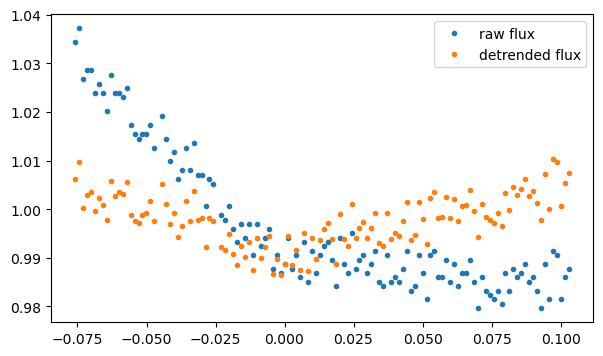

--- Basic information on dataset: ---
  Number of points     = 124
  Baseline  = 0.9978045
  time step between measurements  = 0.0014300000000000007
  base date  = 2454558.3974077

--- Best-Fit: ---
  # models    = 297647
  depth d     = 0.006500000000000001
  duration T  = 0.0448
  start t1    = -0.025717399999999974
  chi2        = 314.19096884114674
  chi2_red    = 2.5966195771995597
  degrees of freedom          = 121


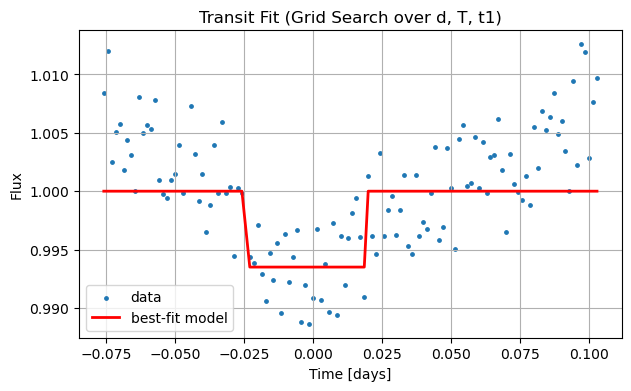

In [16]:
import numpy as np
import matplotlib.pyplot as plt

##########################################################
# Transit model: fitting simple box-shaped transit on a normalized baseline (= 1)
# Parameters:
# - time: time array
# - t_transit: transit duration T (days)
# - d_transit: transit depth d (relative flux drop, e.g. 0.01 = 1%)
# - t1: transit start time (days)
# Returns:
# - flux_model: model flux values at each time stamp
#########################################################

def create_flux_model(time, t_transit,d_transit,t1):
    t2=t1+t_transit
    flux_model=np.ones_like(time)
    in_window = (time >= t1) & (time <= t2)
    flux_model[in_window] = 1.0 - d_transit
    return flux_model

#########################################################
# Chi-square statistic for model comparison:
# chi2 = sum( ((data - model) / sigma)**2 )
# sigma can be a float (constant uncertainty) or an array (per-point uncertainties)
#########################################################
def chi2_test(flux, flux_model, sigma):
    return np.sum(((flux - flux_model) / sigma)**2)

#########################################################
# Fitting function
# Scans over transit duration T, transit depth d, and transit start time t1
# Keeps the parameter set with the minimum chi2
#########################################################

def fit_transit(time, flux, sigma, d_grid, T_grid, t1_step):
    # Define the allowed time window from the data
    t_min = time.min()
    t_max = time.max()

   # Initialize "best-fit" storage
    best_chi2 = np.inf
    best_d = None
    best_T = None
    best_t1 = None
    best_model = None

    # Count the models that are tested
    count = 0
    # Loop over candidate transit durations 
    for T in T_grid:
        # Physics test: negative or zero duration makes no sense
        if T <= 0:
            continue

        # For a given duration, restrict t1 so that the transit fully fits into the data window
        t1_min = t_min
        t1_max = t_max - T
        
        # Physics test: End of transit must be after start of transit
        if t1_max <= t1_min:
            continue

        # Build the grid of candidate start times t1
        # The additional + 0.5*t1_step ensures that the upper boundary is included
        # despite floating-point rounding and the half-open nature of np.arange.
        t1_grid = np.arange(t1_min, t1_max + 0.5 * t1_step, t1_step)

        # Loop over candidate transit depths 
        for d in d_grid:
            
            # Physics test: negative depth makes no sense
            if d < 0:
                continue

            # Loop over candidate start times (shifting the transit along the timeline)
            for t1 in t1_grid:

                count = count + 1
                # Generate the model light curve for this parameter set
                model = create_flux_model(time, T, d, t1)
                
                # Compute chi-square between observed flux and model
                chi2 = chi2_test(flux, model, sigma)

                # Update best-fit if this chi2 is smaller
                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_d = d
                    best_T = T
                    best_t1 = t1
                    best_model = model
    # Return best-fit parameters and the best-fit model curve
    return best_d, best_T, best_t1, best_chi2, best_model, count


########################################################
# Step 1: Load the Kepler transit dataset
# Columns:
# - time: time stamps
# - flux: noisy observed flux
# - flux_err: relative flux uncertainty
#########################################################

transitdata = "UID_0057087_data_AXA_010.tbl.txt"

rows = []
with open(transitdata, "r") as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        if s.startswith("\\"):   # Metadata
            continue
        if s.startswith("|"):    # header, erc
            continue
        # from here on: data
        rows.append(s)

data = np.loadtxt(rows)

# Column order (from file description):
# 0 HJD
# 1 RELATIVE_DATE
# 2 PHASE
# 3 RELATIVE_FLUX
# 4 RELATIVE_FLUX_UNCERTAINTY
# 5 RELATIVE_FLUX_WITHOUT_SYSTEMATICS


# Extract relevant columns
# Use detrended flux, because my fitting function is not able to deal with systematic errors
# Use relative date to geht a numericall robust grid and small numbers
hjd = data[:, 0]
time = data[:, 1]
flux = data[:, 5]
flux_err = data[:, 4]

# Determine base_date
base_date = np.median(hjd - time)


# Plot raw flux vs detrended flux
plt.figure(figsize=(7,4))
plt.plot(time, data[:,3], ".", label="raw flux")
plt.plot(time, data[:,5], ".", label="detrended flux")
plt.legend()
plt.show()

# Number of data points in the set
N = time.size

# Start with calculaton of robust baseline estimate:
# Median is stable even if a small fraction of points are in transit
baseline = np.median(flux)
# Normalize flux so that the baseline is approximately 1
flux = flux / baseline
flux_err = flux_err / baseline     # scale uncertainties consistently
sigma = flux_err


#########################################################
# Define search grids for transit parameters
# - d_grid: transit depth candidates: (0 ... 5%)
# - T_grid: transit duration candidates: (0.02 ... 0.33) (in days)
# - t1_step: grid step size for transit start time, chosen from the data sampling
#########################################################

d_grid = np.linspace(0.0, 0.05, 101)      # Tiefen 0 ... 5%
T_grid = np.linspace(0.02, 0.33, 101)      # Dauern in Tagen (Beispiel)
dt = np.diff(time)
t1_step = np.median(dt)

# Basic dataset information

print("--- Basic information on dataset: ---")
print("  Number of points     =", N)
print ("  Baseline  =", baseline)
print("  time step between measurements  =", t1_step)
print("  base date  =", base_date)
print("")

#Fit of the transit
best_d, best_T, best_t1,  best_chi2, best_model, models = fit_transit(time, flux, sigma, d_grid, T_grid, t1_step)

# Print best-fit results and compute reduced chi-square
# We fit three parameters (d, T, t1) --> degrees of freedom = N - 3
print("--- Best-Fit: ---")
print("  # models    =", models)
print("  depth d     =", best_d)
print("  duration T  =", best_T)
print("  start t1    =", best_t1)
print("  chi2        =", best_chi2)
dof = N - 3
chi2_red = best_chi2 / dof
print("  chi2_red    =", chi2_red)
print("  degrees of freedom          =", dof)

# Plot data and best-fit model
plt.figure(figsize=(7,4))
plt.scatter(time, flux, s=6, label="data")
plt.plot(time, best_model, lw=2, color="r", label="best-fit model")
plt.xlabel("Time [days]")
plt.ylabel("Flux")
plt.title("Transit Fit (Grid Search over d, T, t1)")
plt.legend()
plt.grid(True)
plt.show()



## Comparison of real transit with my fit

- transit time T: my fit gives a value of 0.0448 days, the real value is 0.0468 days. The difference is $\sim 3 min$
- transit depth d: my fit gives 0.0065, the real value is 0,00852. The difference is $\sim 20$ percent.
- transit startting time: my fit gives -0.0257174 days, the real value is - 0.0234 days. The difference is $\sim -3 min$.

Overall, that is quite good for such a simple model! $χ^2_{red}$ is 2.6 which means, that the fit does not explain the data as it would be expected with the assumed errors. But that is no surprise: I model the transit with a box. In reality, there is no sudden drop of flux at a transit and I would have to use a more realistic model (trapezoidal) to get better results. 


## Literature

- "Numerical Python in Astronomy and Astrophysics" (Schmidt, Völshow), Springer, 2021 